# Multi-input Gradient Explainer MNIST Example

Here we demonstrate how to use GradientExplainer when you have multiple inputs to your Keras/TensorFlow model. To keep things simple but also mildly interesting we feed two copies of MNIST into our model, where one copy goes into a conv-net layer and the other copy goes directly into a feedforward network.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D

# load the MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# define our model
input1 = Input(shape=(28,28,1))
input2 = Input(shape=(28,28,1))
input2c = Conv2D(32, kernel_size=(3, 3), activation='relu')(input2)
joint = tf.keras.layers.concatenate([Flatten()(input1), Flatten()(input2c)])
out = Dense(10, activation='softmax')(Dropout(0.2)(Dense(128, activation='relu')(joint)))
model = tf.keras.models.Model(inputs = [input1, input2], outputs=out)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [2]:
# fit the model
model.fit([x_train, x_train], y_train, epochs=3)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 32s 535us/sample - loss: 0.1623 - accuracy: 0.9507
Epoch 2/3
60000/60000 [==============================] - 31s 525us/sample - loss: 0.0635 - accuracy: 0.9801
Epoch 3/3
60000/60000 [==============================] - 31s 517us/sample - loss: 0.0442 - accuracy: 0.9852


## Explain the predictions made by the model using GradientExplainer

In [3]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [x_train, x_train])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([x_test[:3], x_test[:3]])

In [4]:
# since the model has 10 outputs we get a list of 10 explanations (one for each output)
print(len(shap_values))

10


In [5]:
# since the model has 2 inputs we get a list of 2 explanations (one for each input) for each output
print(len(shap_values[0]))

2


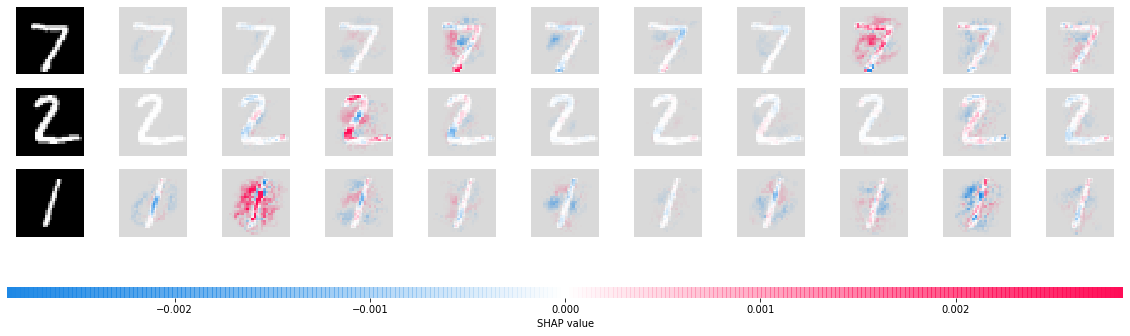

In [6]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values[i][0] for i in range(10)], x_test[:3])

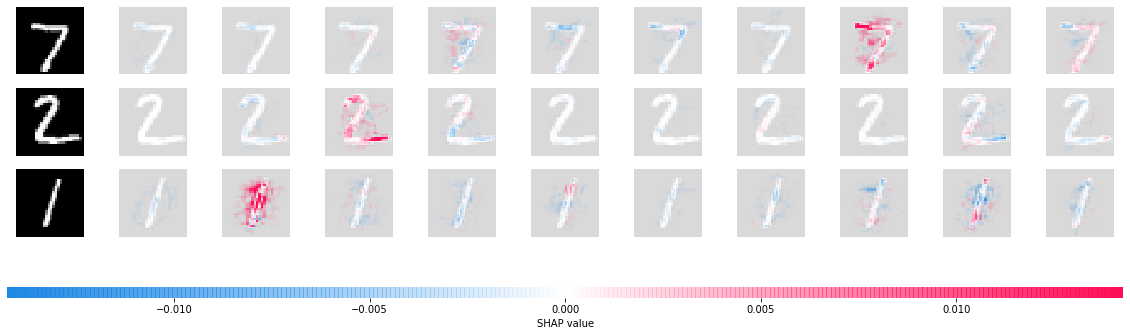

In [7]:
# here we plot the explanations for all classes for the second input (this is the conv-net input)
shap.image_plot([shap_values[i][1] for i in range(10)], x_test[:3])

## Estimating the sampling error

By setting `return_variances=True` we get an estimate of how accurate our explanations are. We can see that the default number of samples (200) that were used provide fairly low variance estimates (compared to the magnitude of the shap_values above). Note that you can always use the `nsamples` parameter to control how many samples are used.

In [8]:
# get the variance of our estimates
shap_values, shap_values_var = explainer.shap_values([x_test[:3], x_test[:3]], return_variances=True)

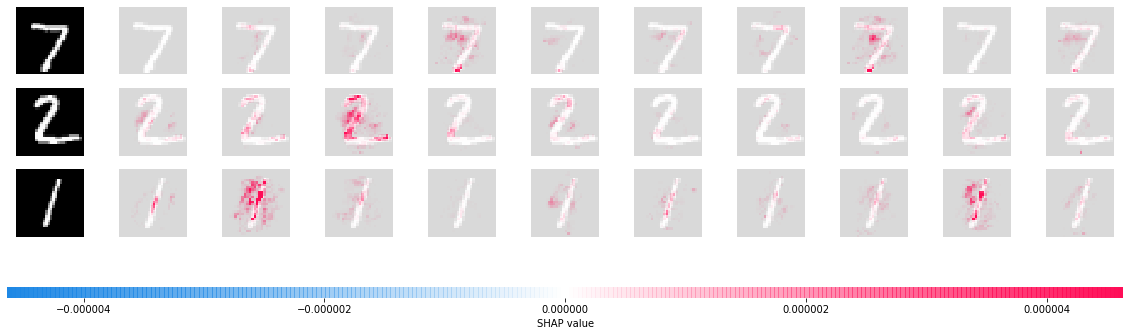

In [9]:
# here we plot the explanations for all classes for the first input (this is the feed forward input)
shap.image_plot([shap_values_var[i][0] for i in range(10)], x_test[:3])